# Fine-tuning R-CNN

In [42]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import matplotlib.pyplot as plt

## Build model

We use pytorch implementation of FasterRCNN. The FasterRCNN (and MaskRCNN) is implemented with the following structure:

- model
    - transform
    - backbone
        - body (ResNet50)
        - feature pyramid network
    - region proposal network
        - AnchorGenerator
        - RPNHead
            - cls_logits (objectness)
            - bbox_pred
    - ROIHeads
        - MultiScaleROIAlign
        - TwoMLPHead
        - FastRCNNPredictor
            - cls_score
            - bbox_pred
        - MaskRCNNHeads
        - MaskRCNNPredictor
            - mask_fcn_logits

The basic operation can be read out of: https://github.com/pytorch/vision/blob/master/torchvision/models/detection/generalized_rcnn.py#L44 An image is passed through the backbone, generating a set of feature maps. The features maps are then passed to the RPN, which outputs a set of $K$ region proposals. The proposals are passed, along with the feature maps, to the ROIHeads, combine these arguments to produce a pseudo-batch of $K$ image crops for classification. The effect of this is a multi-head network, where one head, the ROIHead, is trained based on the outputs of the other head, the RPN. Each, however, are trained with respect to a single loss function, and the entire system is differentiable end-to-end, although for stability purposes, they are trained in an alternating fine-tuning procedure.

## Create synthetic dataset

In [43]:
# from skimage.io import imsave
# from src.models import fnet_cycle
# from src.style_transfer import draw_content

# img_shape = (None, None, 1)

# g_BA = fnet_cycle(img_shape, 32)
# g_BA.load_weights('./weights/g_ba_140.h5')


# def synthesise_training_image():

#     # draw mask
#     nb_cells = np.random.randint(100, 400)
#     canvas, mask, bboxes = draw_content(np.zeros((256, 256)), nb_cells)

#     # synthesis texture
#     img = g_BA.predict(2 * canvas[None, ..., None] - 1)
# #     img = torch.tensor(img).permute((0, 3, 1, 2))

#     # instances are encoded as different colors
#     obj_ids = np.unique(mask)
#     # first id is the background, so remove it
#     obj_ids = obj_ids[1:]
#     # split into instance masks
#     masks = mask == obj_ids[:, None, None]

#     boxes = np.vstack(bboxes)
#     labels = np.ones((nb_cells,))#, dtype=torch.int64)

#     return img, masks, boxes, labels

# for idx in range(2):

#     img, masks, boxes, labels = synthesise_training_image()
#     img = (img - np.min(img)) / (np.max(img) - np.min(img))
#     imsave('./synthetic/img_%04d.png' % idx, img.squeeze())

#     np.save('./synthetic/bbox_%04d.npy' % idx, boxes)
#     np.save('./synthetic/masks_%04d.npy' % idx, masks)

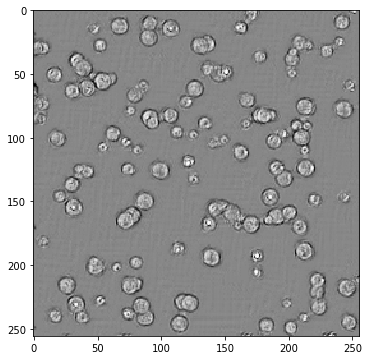

In [44]:
from skimage.io import imread

fig, ax = plt.subplots(figsize=(6, 6))
img = imread('/Users/jcboyd/Desktop/tracking-lympochytes/synthetic/img_0001.png')
ax.imshow(img, cmap='Greys')

In [45]:
import torch

class SyntheticDataset(object):

    def __init__(self, base_dir, transforms=None, classes=['cls1', 'cls2']):

        self.base_dir = base_dir
        self.transforms = transforms

        self.imgs = sorted(filter(lambda x : x.startswith('img'),  os.listdir(base_dir)))
        self.bboxes = sorted(filter(lambda x : x.startswith('bbox'), os.listdir(base_dir)))
        self.masks = sorted(filter(lambda x : x.startswith('masks'), os.listdir(base_dir)))

    def __getitem__(self, idx):

        # load images and masks
        img_path = os.path.join(self.base_dir, self.imgs[idx])
        img = imread(img_path)[None, ...] / 2 ** 16
        img = torch.as_tensor(img, dtype=torch.float32)

        masks = np.load(os.path.join(self.base_dir, self.masks[idx]))
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        boxes = np.load(os.path.join(self.base_dir, self.bboxes[idx]))
        boxes = torch.as_tensor(boxes, dtype=torch.uint8)

        labels = torch.ones(boxes.shape[0], dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        image_id = torch.tensor([idx])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((labels.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

sd = SyntheticDataset('/Users/jcboyd/Desktop/tracking-lympochytes/synthetic/')
img, target = sd[1]

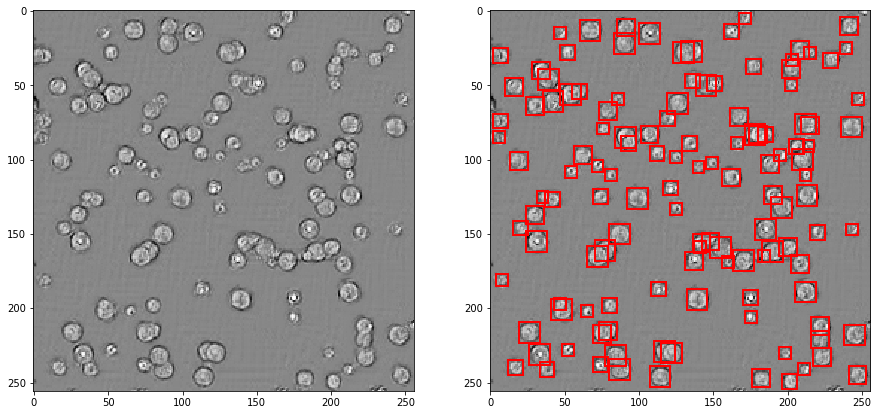

In [46]:
fig, axes = plt.subplots(figsize=(15, 15), ncols=2)

plt_img = img.squeeze()

axes[0].imshow(plt_img, cmap='Greys')
axes[1].imshow(plt_img, cmap='Greys')

for i, bb in enumerate(target['boxes']):

    x_min, y_min, x_max, y_max = bb

    colour = 'red' # if target['cls'] == 1 else 'green'

    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                          linewidth=2, edgecolor=colour, facecolor='none')
    axes[1].add_patch(rect)

## Model training - fine tune

In [47]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model_name = 'fasterrcnn'  # 'maskrcnn'

nb_classes = 2  # including background

# load an instance segmentation model pre-trained on COCO
if model_name == 'fasterrcnn':
    rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                                box_detections_per_img=200)
else:
    rcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# get the number of input features for the classifier
in_features = rcnn.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, nb_classes)

if model_name == 'maskrcnn':

    # now get the number of input features for the mask classifier
    in_features_mask = rcnn.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # and replace the mask predictor with a new one
    rcnn.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      nb_classes)

In [48]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
rcnn.to(device)

# construct an optimizer
params = [p for p in rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from src.engine import train_one_epoch, evaluate

nb_epochs = 5

for epoch in range(nb_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

# save model
save_path = './weights/rcnn_%02depochs.torch' % nb_epochs
torch.save(model.state_dict(), save_path)

## Model evaluation

In [49]:
from src.utils import get_files, get_data

base_dir = '/Users/jcboyd/Dropbox/test_crops/'

experiment = 'raji_target'
days = 3

train_imgs, _, test_imgs = get_files(base_dir, experiment, days)
# test_imgs = train_imgs

No. train images: 36
No. val images: 0
No. test images: 36


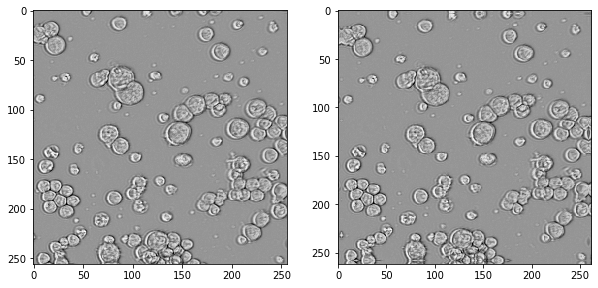

In [50]:
from skimage.io import imread

idx = 35
pad_width = 3

base_dir = '/Users/jcboyd/Dropbox/test_crops/'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = os.path.join(base_dir, 'phase_contrast', test_imgs[idx])
img = imread(file_path) / 255.

img = torch.tensor(img[None, ...]).float()

from torch.nn import ReflectionPad2d

padded_img = ReflectionPad2d(pad_width)(img[None])

fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes[0].imshow(img.squeeze(), cmap='Greys')
axes[1].imshow(padded_img.squeeze(), cmap='Greys')

In [51]:
# load model
# nb_epochs = 5
# save_path = './weights/rcnn_%02depochs.torch' % nb_epochs

save_path = './weights/rcnn_synthetic.torch'

rcnn.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
rcnn = rcnn.eval()

with torch.no_grad():
    prediction = rcnn([padded_img[0].to(device)])

In [63]:
rcnn

torchvision.models.detection.faster_rcnn.FasterRCNN

In [52]:
prediction

[{'boxes': tensor([[2.7935e+01, 2.0052e+02, 4.1450e+01, 2.1185e+02],
          [5.6145e+00, 2.4725e+02, 1.9065e+01, 2.5810e+02],
          [2.3854e+02, 1.1936e+02, 2.5123e+02, 1.3098e+02],
          [1.8239e+02, 9.6082e+01, 1.9661e+02, 1.0856e+02],
          [1.5130e+02, 2.3346e+02, 1.6351e+02, 2.4433e+02],
          [7.2978e+00, 1.5456e+02, 2.0734e+01, 1.6664e+02],
          [1.2349e+02, 1.6814e+02, 1.3519e+02, 1.7928e+02],
          [2.2179e+02, 1.8382e+02, 2.3489e+02, 1.9560e+02],
          [1.3154e+01, 1.4267e+01, 2.7675e+01, 2.7413e+01],
          [8.3044e+01, 1.3291e+02, 9.8082e+01, 1.4662e+02],
          [1.1452e+01, 1.9579e+02, 2.4892e+01, 2.0758e+02],
          [1.7979e+02, 1.2875e+02, 1.9313e+02, 1.3991e+02],
          [3.5667e+01, 2.2974e+02, 4.8736e+01, 2.4035e+02],
          [2.0711e+02, 6.9962e+01, 2.2085e+02, 8.1837e+01],
          [5.0272e+00, 8.7783e+01, 1.3840e+01, 9.7660e+01],
          [2.8465e+01, 1.7911e+02, 4.2373e+01, 1.9032e+02],
          [1.3245e+02, 1.7736e+

In [19]:
from src.nms import non_max_suppression_fast

bboxes = prediction[0]['boxes'].numpy()
print('Number of bboxes: %d' % bboxes.shape[0])

bboxes = np.clip(bboxes - pad_width, 0, 256)  # remove padding

areas = ((bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 2] - bboxes[:, 0]))

min_size = 5
max_size = 500

idx_size = (min_size < areas) * (areas < max_size)
bboxes = bboxes[idx_size]
print('After filtering size: %d' % bboxes.shape[0])

bboxes = non_max_suppression_fast(bboxes, overlapThresh=0.5)
print('After NMS: %d' % bboxes.shape[0])

Number of bboxes: 155
After filtering size: 122
After NMS: 105


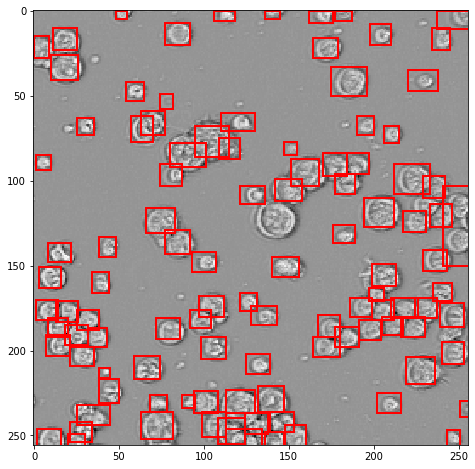

In [20]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

plt_img = img.mul(255).permute(1, 2, 0).byte().numpy().squeeze()

ax.imshow(plt_img, cmap='Greys')

for i, bb in enumerate(bboxes):

    x_min, y_min, x_max, y_max = bb

    cls = prediction[0]['labels'][i].item()
    colour = 'red' if cls == 1 else 'green'

    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                          linewidth=2, edgecolor=colour, facecolor='none')
    ax.add_patch(rect)

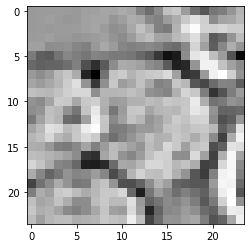

In [31]:
def get_crop(img, bb):

    x_min, y_min, x_max, y_max = list(map(int, list(bb)))

    center_y, center_x = (y_min + y_max) // 2, (x_min + x_max) // 2

    pad = 12

    padded_img = np.pad(img.squeeze(), pad_width=pad, mode='reflect')
    crop = padded_img[center_y:center_y + 2 * pad, center_x:center_x + 2 * pad]

    return crop

idx = np.random.randint(bboxes.shape[0])

bb = bboxes[idx]
crop = get_crop(img, bb)

plt.imshow(crop, cmap='Greys')

### Export all region proposals

In [26]:
N = len(test_imgs)

for idx in range(N):

    file_path = os.path.join(base_dir, 'phase_contrast', test_imgs[idx])
    img = imread(file_path) / 255.

    torch_img = torch.tensor(img[None, ...]).float()

    with torch.no_grad():
        prediction = rcnn([torch_img.to(device)])

    bboxes = prediction[0]['boxes'].numpy()

    save_path = './synthetic/predicted_bboxes_%s_%04d.npy' % (experiment, idx)
    print('Saving %s...' % save_path)

    np.save(save_path, bboxes)

Saving ./synthetic/predicted_bboxes_raji_target_0000.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0001.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0002.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0003.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0004.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0005.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0006.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0007.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0008.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0009.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0010.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0011.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0012.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0013.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0014.npy...
Saving ./synthetic/predicted_bboxes_raji_target_0015.npy...
Saving ./synthetic/predicted_bboxes_raji

## Classify bounding box proposals

In [27]:
from sklearn.model_selection import train_test_split

random_state = 42

mode = 'two-class'
acquisition = 'raw'

x_train = np.load('./x_train_%s_%s.npy' % (acquisition, mode))[:, :, :, np.newaxis]
y_train = np.load('./y_train_%s_%s.npy' % (acquisition, mode))

# exclude background crops
x_train = x_train[y_train[:, 0] == 0]
y_train = y_train[y_train[:, 0] == 0][:, 1:3]

x_train, x_test, y_train, y_test = train_test_split(x_train,
                                                    y_train,
                                                    test_size=0.1,
                                                    random_state=random_state)

# take image mean (rather than mean image) to facilitate sliding window
image_mean = np.mean(x_train)

In [28]:
from src.models import MultiFCN

model_tr, model = MultiFCN()
model.load_weights('./weights_classifier_multi.h5')

In [29]:
def filter_bboxes(bboxes):
    areas = ((bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 2] - bboxes[:, 0]))

    min_size = 3
    max_size = 500

    idx_size = (min_size < areas) * (areas < max_size)
    bboxes = bboxes[idx_size]
    bboxes = non_max_suppression_fast(bboxes, overlapThresh=0.5)

    return bboxes

def get_preds(img, bboxes):

    img_numpy = img - image_mean

    for bb in bboxes:

        crop = get_crop(img_numpy, bb)

        pred_proba_obj, pred_proba_cls, pred_proba_bbs = model.predict(crop[None, ..., None])
        
        yield np.argmax(pred_proba_cls[:, 0, 0, :], axis=1) + 1, bb

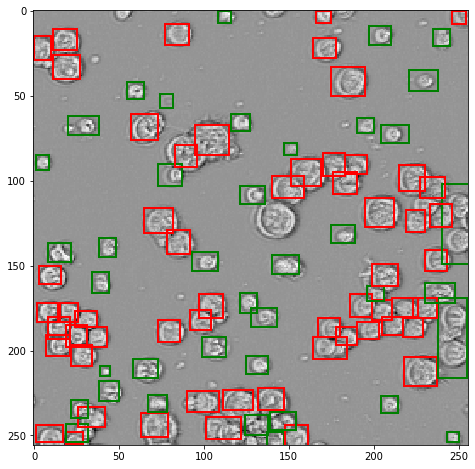

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

idx = 33

file_path = os.path.join(base_dir, 'phase_contrast', test_imgs[idx])
img = imread(file_path) / 255.
ax.imshow(img, cmap='Greys')

bboxes = np.load('./synthetic/predicted_bboxes_%s_%04d.npy' % (experiment, idx))
bboxes = filter_bboxes(bboxes)

for pred, bb in get_preds(img, bboxes):

    x_min, y_min, x_max, y_max = bb

    if pred != 0:

        colour = 'red' if pred == 1 else 'green'

        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                              linewidth=2, edgecolor=colour, facecolor='none')
        ax.add_patch(rect)

In [34]:
from src.utils import create_masks

b_masks, d_masks = [], []
b_counts, d_counts = [], []

N = len(test_imgs)

for idx in range(N):

    file_path = os.path.join(base_dir, 'phase_contrast', test_imgs[idx])
    img = imread(file_path) / 255.
    ax.imshow(img, cmap='Greys')

    bboxes = np.load('./synthetic/predicted_bboxes_%s_%04d.npy' % (experiment, idx))
    bboxes = filter_bboxes(bboxes)

    b_centers, d_centers = [], []

    for pred, bb in get_preds(img, bboxes):

        x_min, y_min, x_max, y_max = bb

        if pred == 1:
            b_centers.append([int((y_max + y_min) / 2), int((x_max + x_min) / 2)])
        else:
            d_centers.append([int((y_max + y_min) / 2), int((x_max + x_min) / 2)])

    b_centers = np.array(b_centers)
    d_centers = np.array(d_centers)

    b_counts.append(b_centers.shape[0])
    d_counts.append(d_centers.shape[0])

    h, w = img.shape
    
    b_mask, d_mask = create_masks(h, w, b_centers, d_centers)

    b_masks.append(b_mask)
    d_masks.append(d_mask)

## Evaluation

In [35]:
from src.utils import import_annotations

annotations_dir = './zenodo/test/labels/'
plate = 'VID193_A6_4'

arr_num_dead, arr_num_raji, gt_b_masks, gt_d_masks = import_annotations(annotations_dir, plate)

/Users/jcboyd/Desktop/tracking-lympochytes/src/utils.py:229: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 229 of the file /Users/jcboyd/Desktop/tracking-lympochytes/src/utils.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(fp)


In [36]:
N = len(arr_num_raji)

mean_count_err_raji = np.mean(np.abs(np.array(b_counts) - arr_num_raji[:N]))
mean_count_err_dead = np.mean(np.abs(np.array(d_counts) - arr_num_dead[:N]))

mean_perc_err_raji = np.mean(np.abs(np.array(b_counts) - arr_num_raji[:N]) / arr_num_raji[:N])
mean_perc_err_dead = np.mean(np.abs(np.array(d_counts) - arr_num_dead[:N]) / arr_num_dead[:N])

print('Mean err. RAJI %.04f' % mean_count_err_raji)
print('Mean err. Dead %.04f' % mean_count_err_dead)

print('Mean perc err. RAJI %.04f' % mean_perc_err_raji)
print('Mean perc err. Dead %.04f' % mean_perc_err_dead)

Mean err. RAJI 8.3056
Mean err. Dead 3.2778
Mean perc err. RAJI 0.1547
Mean perc err. Dead 0.0980


In [37]:
from src.utils import evaluate

b_tps_list, b_fps_list, b_fns_list = [], [], []
d_tps_list, d_fps_list, d_fns_list = [], [], []

for i in range(N):
    tps, fps, fns = evaluate(gt_b_masks[i], b_masks[i], max_dist=10)
    b_tps_list.append(tps)
    b_fps_list.append(fps)
    b_fns_list.append(fns)

    tps, fps, fns = evaluate(gt_d_masks[i], d_masks[i], max_dist=10)
    d_tps_list.append(tps)
    d_fps_list.append(fps)
    d_fns_list.append(fns)

In [38]:
from src.utils import calculate_recall, calculate_precision, calculate_f1

tps = np.sum(b_tps_list)
fps = np.sum(b_fps_list)
fns = np.sum(b_fns_list)

precision = calculate_precision(tps, fps)
recall = calculate_recall(tps, fns)
f1 = calculate_f1(precision, recall)

print('Precision %.04f Recall %0.4f F1 %.04f' % (precision, recall, f1))

Precision 0.8207 Recall 0.8176 F1 0.8191


In [39]:
tps = np.sum(d_tps_list)
fps = np.sum(d_fps_list)
fns = np.sum(d_fns_list)
 
precision = calculate_precision(tps, fps)
recall = calculate_recall(tps, fns)
f1 = calculate_f1(precision, recall)

print('Precision %.04f Recall %0.4f F1 %.04f' % (precision, recall, f1))

Precision 0.6293 Recall 0.8889 F1 0.7369


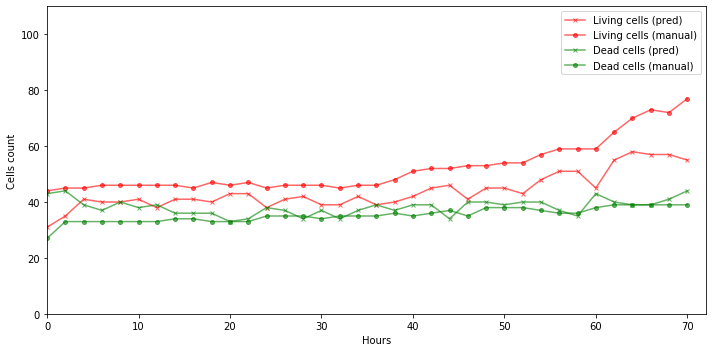

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))

x_range = range(0, 2 * N, 2)

ax.set_xlim([0, 72])
ax.set_ylim([0, 110])

ax.plot(x_range, np.array(b_counts), marker='x', markersize=4,
        color='Red', label='Living cells (pred)', alpha=0.6)
ax.plot(x_range, arr_num_raji, marker='o', markersize=4,
        color='Red', label='Living cells (manual)', alpha=0.6)
ax.plot(x_range, np.array(d_counts), marker='x', markersize=4,
        color='Green', label='Dead cells (pred)', alpha=0.6)
ax.plot(x_range, arr_num_dead, marker='o', markersize=4,
        color='Green', label='Dead cells (manual)', alpha=0.6)

ax.set_xlabel('Hours')
ax.set_ylabel('Cells count')

plt.tight_layout()
plt.legend()

plt.show()